In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from sequence_logo_helper_protein import plot_protein_logo as plot_protein_logo_scrambler
from sequence_logo_helper_protein import plot_importance_scores

import pandas as pd

from keras.backend.tensorflow_backend import set_session

from adam_accumulate_keras import *

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[-1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

class NopTransformer(iso.ValueTransformer) :
    
    def __init__(self, n_classes) :
        super(NopTransformer, self).__init__('nop', (n_classes, ))
        
        self.n_classes = n_classes
    
    def transform(self, values) :
        return values
    
    def transform_inplace(self, values, transform) :
        transform[:] = values
    
    def transform_inplace_sparse(self, values, transform_mat, row_index) :
        transform_mat[row_index, :] = np.ravel(values)

from seqprop_protein_utils import *
from seqprop_rosetta_kl_helper import _get_kl_divergence_numpy, _get_smooth_kl_divergence_numpy, _get_smooth_circular_kl_divergence_numpy
from seqprop_rosetta_kl_helper import _get_kl_divergence_keras, _get_smooth_kl_divergence_keras, _get_smooth_circular_kl_divergence_keras
from basinhopping_rosetta import *

from trrosetta_single_model_no_msa_batched_simpler_1d_features_2 import load_saved_predictor, InstanceNormalization, msa2pssm, reweight, fast_dca, keras_collect_features, pssm_func


Using TensorFlow backend.


In [2]:

dataset_name = "hallucinated_1517"

fig_name = dataset_name

def make_a3m(seqs) :
    alphabet = np.array(list("ARNDCQEGHILKMFPSTWYV-"), dtype='|S1').view(np.uint8)
    msa = np.array([list(s) for s in seqs], dtype='|S1').view(np.uint8)
    for i in range(alphabet.shape[0]):
        msa[msa == alphabet[i]] = i

    msa[msa > 20] = 20
    
    return msa

a3m = ["GQTFLFIHVGDDPSQMNWLHHFLQQRGMTYTEVSIPADDPSYLERTVKNALELAKESRKKGTPILIYVDDPSAASTVAKAIQEAGLDNVWVFRNGELRPV"]

msa_one_hot = np.expand_dims(one_hot_encode_msa(make_a3m(a3m)), axis=0)[:, :1, ...]

print(msa_one_hot.shape)


(1, 1, 100, 21)


In [3]:
#Create test data

x_test = msa_one_hot[:, :1, :, :20]

print(x_test.shape)

x_train = np.transpose(msa_one_hot[:, ..., :20], (1, 0, 2, 3))

print(x_train.shape)


(1, 1, 100, 20)
(1, 1, 100, 20)


In [4]:
#Initialize sequence encoder

seq_length = x_test.shape[2]

residues = list("ARNDCQEGHILKMFPSTWYV")
residue_map = {
    residue : residue_ix
    for residue_ix, residue in enumerate(residues)
}

encoder = IdentityEncoder(seq_length, residue_map)


In [5]:
#Define sequence templates

sequence_template = '$' * seq_length

sequence_mask = np.array([1 if sequence_template[j] == '$' else 0 for j in range(len(sequence_template))])


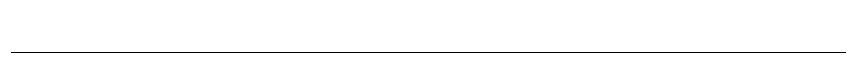

In [6]:
#Calculate background distribution

x_mean = np.tile(np.array([0.07892653, 0.04979037, 0.0451488 , 0.0603382 , 0.01261332,
    0.03783883, 0.06592534, 0.07122109, 0.02324815, 0.05647807,
    0.09311339, 0.05980368, 0.02072943, 0.04145316, 0.04631926,
    0.06123779, 0.0547427 , 0.01489194, 0.03705282, 0.0691271 ]).reshape(1, -1), (seq_length, 1))

x_mean_logits = np.log(x_mean)

plot_protein_logo_scrambler(residue_map, np.copy(x_mean), sequence_template=sequence_template, figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=seq_length)


In [7]:
#Calculate mean test seqeunce kl-divergence against background

x_test_clipped = np.clip(np.copy(x_test[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_test_clipped * np.log(x_test_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_test_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 4.180681716755644


In [8]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [9]:
#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_st(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 20))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 20))

def sample_pwm_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 20))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 20))

#Generator helper functions
def initialize_sequence_templates(generator, encoder, sequence_templates, background_matrices, model_suffix='') :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = encoder(sequence_template).reshape((1, len(sequence_template), 20))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['$', '@'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0

        onehot_mask = np.zeros((1, len(sequence_template), 20))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == '$' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense' + model_suffix).set_weights([embedding_templates])
    generator.get_layer('template_dense' + model_suffix).trainable = False

    generator.get_layer('mask_dense' + model_suffix).set_weights([embedding_masks])
    generator.get_layer('mask_dense' + model_suffix).trainable = False
    
    generator.get_layer('background_dense' + model_suffix).set_weights([embedding_backgrounds])
    generator.get_layer('background_dense' + model_suffix).trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=1, sample_mode='st', model_suffix='') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 20))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='zeros', name='background_dense' + model_suffix)

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='zeros', name='template_dense' + model_suffix)
    onehot_mask_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='ones', name='mask_dense' + model_suffix)

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 20), name='masking_layer' + model_suffix)
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer' + model_suffix)
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm' + model_suffix)
    
    #Initialize sampling layers
    sample_func = None
    if sample_mode == 'st' :
        sample_func = sample_pwm_st
    elif sample_mode == 'gumbel' :
        sample_func = sample_pwm_gumbel
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer' + model_suffix)
    sampling_layer = Lambda(sample_func, name='pwm_sampler' + model_suffix)
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 20)), (1, 0, 2, 3, 4)), name='permute_layer' + model_suffix)
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([background_layer([raw_logits, onehot_background]), onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        #Tile each PWM to sample from and create sample axis
        pwm_logits_upsampled = upsampling_layer(pwm_logits)
        sampled_pwm = sampling_layer(pwm_logits_upsampled)
        sampled_pwm = permute_layer(sampled_pwm)

        sampled_mask = permute_layer(upsampling_layer(onehot_mask))
        
        return pwm_logits, pwm, sampled_pwm, onehot_mask, sampled_mask
    
    return _sampler_func


In [10]:
#Scrambler network definition

def load_scrambler_network(seq_length, model_suffix='') :

    #Discriminator network definition
    
    seed_input = Lambda(lambda x: K.zeros((1, 1), dtype=tf.int32))
    
    mask_dense = Embedding(1, seq_length, embeddings_initializer='glorot_normal', name='scrambler_mask_dense' + model_suffix)
    
    mask_reshape = Reshape((1, seq_length, 1))
    
    mask_norm = BatchNormalization(axis=-1, name='scrambler_mask_norm' + model_suffix)
    
    mask_act = Activation('softplus')
    
    onehot_to_logits = Lambda(lambda x: 2. * x - 1., name='scrambler_onehot_to_logits' + model_suffix)
    
    scale_logits = Lambda(lambda x: x[1] * K.tile(x[0], (1, 1, 1, 20)), name='scrambler_logit_scale' + model_suffix)
    
    def _scrambler_func(sequence_input) :

        #Final conv out
        final_conv_out = mask_act(mask_norm(mask_reshape(mask_dense(seed_input(sequence_input))), training=True))
        #final_conv_out = mask_act(mask_reshape(mask_dense(seed_input(sequence_input))))
        
        #Scale inputs by importance scores
        scaled_inputs = scale_logits([final_conv_out, onehot_to_logits(sequence_input)])
        
        return scaled_inputs, final_conv_out

    return _scrambler_func


In [11]:
#Keras loss functions

def get_margin_entropy_ame_masked(pwm_start, pwm_end, pwm_background, max_bits=1.0) :
    
    def _margin_entropy_ame_masked(pwm, pwm_mask) :
        conservation = pwm[:, 0, pwm_start:pwm_end, :] * K.log(K.clip(pwm[:, 0, pwm_start:pwm_end, :], K.epsilon(), 1. - K.epsilon()) / K.constant(pwm_background[pwm_start:pwm_end, :])) / K.log(2.0)
        conservation = K.sum(conservation, axis=-1)
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_conservation = K.sum(conservation * mask, axis=-1) / n_unmasked

        margin_conservation = K.switch(mean_conservation > K.constant(max_bits, shape=(1,)), mean_conservation - K.constant(max_bits, shape=(1,)), K.zeros_like(mean_conservation))
    
        return margin_conservation
    
    return _margin_entropy_ame_masked

def get_target_entropy_sme_masked(pwm_start, pwm_end, pwm_background, target_bits=1.0) :
    
    def _target_entropy_sme_masked(pwm, pwm_mask) :
        conservation = pwm[:, 0, pwm_start:pwm_end, :] * K.log(K.clip(pwm[:, 0, pwm_start:pwm_end, :], K.epsilon(), 1. - K.epsilon()) / K.constant(pwm_background[pwm_start:pwm_end, :])) / K.log(2.0)
        conservation = K.sum(conservation, axis=-1)
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_conservation = K.sum(conservation * mask, axis=-1) / n_unmasked

        return (mean_conservation - target_bits)**2
    
    return _target_entropy_sme_masked

def get_weighted_loss(loss_coeff=1.) :
    
    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred
    
    return _min_pred


In [12]:
#Initialize Encoder and Decoder networks
batch_size = 1
#seq_length = 81
n_samples = 4
sample_mode = 'gumbel'

#Load scrambler
scrambler = load_scrambler_network(seq_length)

#Load sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, sample_mode=sample_mode)


In [13]:
#Load trRosetta predictor

def _tmp_load_model(model_path) :

    saved_model = load_model(model_path, custom_objects = {
        'InstanceNormalization' : InstanceNormalization,
        'reweight' : reweight,
        'wmin' : 0.8,
        'msa2pssm' : msa2pssm,
        'tf' : tf,
        'fast_dca' : fast_dca,
        'keras_collect_features' : pssm_func#keras_collect_features
    })
    
    return saved_model

#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../seqprop/examples/rosetta/trRosetta/network/model2019_07')

#model_name = 'model.xaa_batched_no_drop_2.h5' #Without drop
model_name = 'model.xaa_batched.h5' #With drop

model_path = os.path.join(save_dir, model_name)

predictor = _tmp_load_model(model_path)

predictor.trainable = False

predictor.compile(
    loss='mse',
    optimizer=keras.optimizers.SGD(lr=0.1)
)


In [14]:
predictor.inputs

[<tf.Tensor 'input_1:0' shape=(?, ?, 20) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(?, ?, ?, 21) dtype=float32>]

In [15]:
predictor.outputs

[<tf.Tensor 'softmax_3/truediv:0' shape=(?, ?, ?, 37) dtype=float32>,
 <tf.Tensor 'softmax_1/truediv:0' shape=(?, ?, ?, 25) dtype=float32>,
 <tf.Tensor 'softmax_2/truediv:0' shape=(?, ?, ?, 13) dtype=float32>,
 <tf.Tensor 'softmax_4/truediv:0' shape=(?, ?, ?, 25) dtype=float32>]

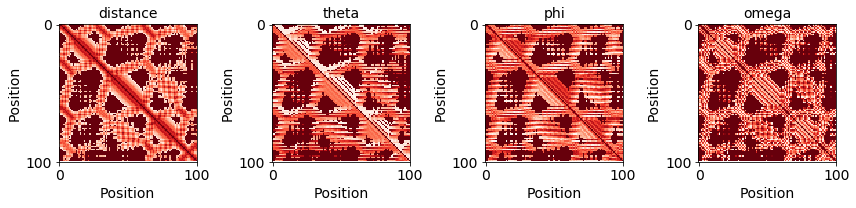

In [16]:
#Test predictor on sequence

save_figs = True

pd, pt, pp, po = predictor.predict(x=[x_test[:, 0, :, :], np.concatenate([x_test, np.zeros((1, 1, x_test.shape[2], 1))], axis=-1)], batch_size=1)

f, ax_list = plt.subplots(1, 4, figsize=(12, 3))

p_list = [
    [pd, 'distance', ax_list[0]],
    [pt, 'theta', ax_list[1]],
    [pp, 'phi', ax_list[2]],
    [po, 'omega', ax_list[3]]
]

for p_keras, p_name, p_ax in p_list :

    p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

    p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

    p_ax.set_title(p_name, fontsize=14)
    p_ax.set_xlabel("Position", fontsize=14)
    p_ax.set_ylabel("Position", fontsize=14)

    plt.sca(p_ax)

    plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
    plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + '_p_distribs.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '_p_distribs.svg')
    plt.savefig(fig_name + '_p_distribs.eps')

plt.show()


In [17]:
#Build scrambler model
scrambler_class = Input(shape=(1,), name='scrambler_class')
scrambler_input = Input(shape=(1, seq_length, 20), name='scrambler_input')

scrambled_pwm, importance_scores = scrambler(scrambler_input)

pwm_logits, pwm, sampled_pwm, _, sampled_mask = sampler(scrambler_class, scrambled_pwm)

scrambler_model = Model([scrambler_input, scrambler_class], [pwm, importance_scores])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, encoder, [sequence_template], [x_mean_logits])

scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [18]:

def _get_kl_divergence_keras(p_dist, p_theta, p_phi, p_omega, t_dist, t_theta, t_phi, t_omega) :
    
    kl_dist = K.mean(K.sum(t_dist * K.log(t_dist / p_dist), axis=-1), axis=(-1, -2))
    kl_theta = K.mean(K.sum(t_theta * K.log(t_theta / p_theta), axis=-1), axis=(-1, -2))
    kl_phi = K.mean(K.sum(t_phi * K.log(t_phi / p_phi), axis=-1), axis=(-1, -2))
    kl_omega = K.mean(K.sum(t_omega * K.log(t_omega / p_omega), axis=-1), axis=(-1, -2))
    
    return K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=1)


In [19]:
#Build Auto-scrambler pipeline

#Define model inputs
ae_scrambler_class = Input(batch_shape=(1, 1), name='ae_scrambler_class')
ae_scrambler_input = Input(batch_shape=(1, 1, seq_length, 20), name='ae_scrambler_input')

scrambled_in, importance_scores = scrambler(ae_scrambler_input)

#Run encoder and decoder
_, scrambled_pwm, scrambled_sample, pwm_mask, sampled_mask = sampler(ae_scrambler_class, scrambled_in)

#Define layer to deflate sample axis
deflate_scrambled_sample = Lambda(lambda x: K.reshape(x, (batch_size * n_samples, 1, seq_length, 20)), name='deflate_scrambled_sample')

#Deflate sample axis
scrambled_sample_deflated = deflate_scrambled_sample(scrambled_sample)

#Make reference prediction on non-scrambled input sequence
collapse_input_layer_non_scrambled = Lambda(lambda x: x[:, 0, :, :], output_shape=(seq_length, 20))
create_msa_layer_non_scrambled = Lambda(lambda x: K.concatenate([x, K.zeros((x.shape[0], x.shape[1], x.shape[2], 1))], axis=-1), output_shape=(1, seq_length, 21))
collapsed_in_non_scrambled = collapse_input_layer_non_scrambled(ae_scrambler_input)
collapsed_in_non_scrambled_msa = create_msa_layer_non_scrambled(ae_scrambler_input)

p_dist_non_scrambled_deflated, p_theta_non_scrambled_deflated, p_phi_non_scrambled_deflated, p_omega_non_scrambled_deflated = predictor([collapsed_in_non_scrambled, collapsed_in_non_scrambled_msa])

#Make prediction on scrambled sequence samples
collapse_input_layer = Lambda(lambda x: x[:, 0, :, :], output_shape=(seq_length, 20))
create_msa_layer = Lambda(lambda x: K.concatenate([x, K.zeros((x.shape[0], x.shape[1], x.shape[2], 1))], axis=-1), output_shape=(1, seq_length, 21))
collapsed_in = collapse_input_layer(scrambled_sample_deflated)
collapsed_in_msa = create_msa_layer(scrambled_sample_deflated)

p_dist_scrambled_deflated, p_theta_scrambled_deflated, p_phi_scrambled_deflated, p_omega_scrambled_deflated = predictor([collapsed_in, collapsed_in_msa])

#Define layer to inflate sample axis
inflate_dist_target = Lambda(lambda x: K.expand_dims(x, axis=1), name='inflate_dist_target')
inflate_theta_target = Lambda(lambda x: K.expand_dims(x, axis=1), name='inflate_theta_target')
inflate_phi_target = Lambda(lambda x: K.expand_dims(x, axis=1), name='inflate_phi_target')
inflate_omega_target = Lambda(lambda x: K.expand_dims(x, axis=1), name='inflate_omega_target')

inflate_dist_prediction = Lambda(lambda x: K.reshape(x, (batch_size, n_samples, seq_length, seq_length, 37)), name='inflate_dist_prediction')
inflate_theta_prediction = Lambda(lambda x: K.reshape(x, (batch_size, n_samples, seq_length, seq_length, 25)), name='inflate_theta_prediction')
inflate_phi_prediction = Lambda(lambda x: K.reshape(x, (batch_size, n_samples, seq_length, seq_length, 13)), name='inflate_phi_prediction')
inflate_omega_prediction = Lambda(lambda x: K.reshape(x, (batch_size, n_samples, seq_length, seq_length, 25)), name='inflate_omega_prediction')

#Inflate sample axis
p_dist_non_scrambled = inflate_dist_target(p_dist_non_scrambled_deflated)
p_theta_non_scrambled = inflate_theta_target(p_theta_non_scrambled_deflated)
p_phi_non_scrambled = inflate_phi_target(p_phi_non_scrambled_deflated)
p_omega_non_scrambled = inflate_omega_target(p_omega_non_scrambled_deflated)

p_dist_scrambled = inflate_dist_prediction(p_dist_scrambled_deflated)
p_theta_scrambled = inflate_theta_prediction(p_theta_scrambled_deflated)
p_phi_scrambled = inflate_phi_prediction(p_phi_scrambled_deflated)
p_omega_scrambled = inflate_omega_prediction(p_omega_scrambled_deflated)

#Cost function parameters
pwm_start = 0
pwm_end = seq_length
target_bits = 1.0

#NLL cost
nll_loss_func = _get_kl_divergence_keras

#Conservation cost
conservation_loss_func = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, target_bits=1.8)

#Entropy cost
entropy_loss_func = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, target_bits=target_bits)
#entropy_loss_func = get_margin_entropy_ame_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, max_bits=target_bits)

#Define annealing coefficient
anneal_coeff = K.variable(0.0)

#Execute NLL cost
nll_loss = Lambda(lambda x: nll_loss_func(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]), name='nll')([
    p_dist_non_scrambled,
    p_theta_non_scrambled,
    p_phi_non_scrambled,
    p_omega_non_scrambled,
    p_dist_scrambled,
    p_theta_scrambled,
    p_phi_scrambled,
    p_omega_scrambled
])

#Execute conservation cost
conservation_loss = Lambda(lambda x: anneal_coeff * conservation_loss_func(x[0], x[1]), name='conservation')([scrambled_pwm, pwm_mask])

#Execute entropy cost
entropy_loss = Lambda(lambda x: (1. - anneal_coeff) * entropy_loss_func(x[0], x[1]), name='entropy')([scrambled_pwm, pwm_mask])

loss_model = Model(
    [ae_scrambler_class, ae_scrambler_input],
    [nll_loss, conservation_loss, entropy_loss]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(loss_model, encoder, [sequence_template], [x_mean_logits])

opt = AdamAccumulate(lr=0.01, beta_1=0.5, beta_2=0.9, accum_iters=2)

loss_model.compile(
    optimizer=opt,
    loss={
        'nll' : get_weighted_loss(loss_coeff=1.0),
        'conservation' : get_weighted_loss(loss_coeff=1.0),
        'entropy' : get_weighted_loss(loss_coeff=10.0)
    }
)


In [20]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scrambler_input (InputLayer)    (None, 1, 100, 20)   0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (1, 1)               0           scrambler_input[0][0]            
__________________________________________________________________________________________________
scrambler_mask_dense (Embedding (1, 1, 100)          100         lambda_1[0][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (1, 1, 100, 1)       0           scrambler_mask_dense[0][0]       
__________________________________________________________________________________________________
scrambler_

In [21]:
loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ae_scrambler_input (InputLayer) (1, 1, 100, 20)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (1, 1)               0           ae_scrambler_input[0][0]         
__________________________________________________________________________________________________
scrambler_mask_dense (Embedding (1, 1, 100)          100         lambda_1[1][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (1, 1, 100, 1)       0           scrambler_mask_dense[1][0]       
__________________________________________________________________________________________________
scrambler_

In [22]:
#Training configuration

#Define number of training epochs
n_iters = 500 * 2

#Define experiment suffix (optional)
experiment_suffix = "_kl_divergence_per_example_gradacc_2_native_bg"

model_name = "autoscrambler_rosetta_" + dataset_name + "_n_iters_" + str(n_iters) + "_n_samples_" + str(n_samples) + "_target_bits_" + str(target_bits).replace(".", "") + experiment_suffix

print("Model save name = " + model_name)


Model save name = autoscrambler_rosetta_hallucinated_1517_n_iters_1000_n_samples_4_target_bits_10_kl_divergence_per_example_gradacc_2_native_bg


In [23]:
#(Re-)Initialize scrambler mask

def reset_generator(scrambler_model, verbose=False) :
    session = K.get_session()
    for layer in scrambler_model.layers :
        if 'scrambler' in layer.name :
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg,'initializer'):
                    initializer_method = getattr(v_arg, 'initializer')
                    initializer_method.run(session=session)
                    if verbose :
                        print('reinitializing layer {}.{}'.format(layer.name, v))

#(Re-)Initialize Optimizer

def reset_optimizer(opt, verbose=False) :
    session = K.get_session()
    for v in opt.__dict__:
        v_arg = getattr(opt, v)
        if hasattr(v_arg,'initializer'):
            initializer_method = getattr(v_arg, 'initializer')
            initializer_method.run(session=session)
            if verbose :
                print('reinitializing optimizer parameter {}'.format(v))


In [24]:
#Reset mask
reset_generator(scrambler_model, verbose=True)
reset_generator(loss_model, verbose=True)
reset_optimizer(opt, verbose=True)

reinitializing layer scrambler_mask_dense.embeddings
reinitializing layer scrambler_mask_norm.gamma
reinitializing layer scrambler_mask_norm.beta
reinitializing layer scrambler_mask_norm.moving_mean
reinitializing layer scrambler_mask_norm.moving_variance
reinitializing layer scrambler_mask_dense.embeddings
reinitializing layer scrambler_mask_norm.gamma
reinitializing layer scrambler_mask_norm.beta
reinitializing layer scrambler_mask_norm.moving_mean
reinitializing layer scrambler_mask_norm.moving_variance
reinitializing optimizer parameter iterations
reinitializing optimizer parameter lr
reinitializing optimizer parameter beta_1
reinitializing optimizer parameter beta_2
reinitializing optimizer parameter decay
reinitializing optimizer parameter accum_iters


In [25]:
#Execute training procedure

class LossHistory(keras.callbacks.Callback) :
    
    def on_train_begin(self, logs={}):
        self.nll_losses = []
        self.entropy_losses = []
        self.conservation_losses = []

    def on_batch_end(self, batch, logs={}) :
        self.nll_losses.append(logs.get('nll_loss'))
        self.entropy_losses.append(logs.get('entropy_loss'))
        self.conservation_losses.append(logs.get('conservation_loss'))

s_test = np.zeros((1, 1))

pwm_test = []
importance_scores_test = []
train_histories = []

for data_ix in range(x_test.shape[0]) :
    
    if data_ix % 100 == 0 :
        print("Optimizing example " + str(data_ix) + "...")
    
    train_history = LossHistory()
    
    # train the autoscrambler
    _ = loss_model.fit(
        [s_test, x_test[data_ix:data_ix+1]],
        [s_test, s_test, s_test],
        epochs=1,
        steps_per_epoch=n_iters,
        callbacks=[train_history]
    )
    
    temp_pwm, temp_importance_scores = scrambler_model.predict_on_batch(x=[x_test[data_ix:data_ix+1], s_test])
    
    pwm_test.append(temp_pwm)
    importance_scores_test.append(temp_importance_scores)
    train_histories.append(train_history)
    
    #Reset mask
    reset_generator(scrambler_model)
    reset_generator(loss_model)
    reset_optimizer(opt)


Optimizing example 0...
Epoch 1/1
1000/1000 [==============================] - 321s 321ms/step - loss: 3.9797 - nll_loss: 3.5458 - conservation_loss: 0.0000e+00 - entropy_loss: 0.4339


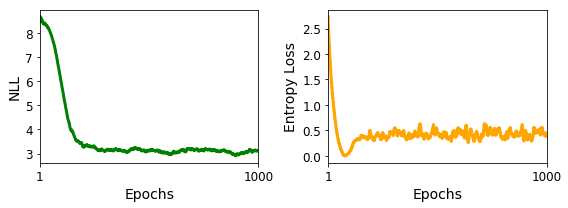

In [26]:

save_figs = True

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

train_history = train_histories[0]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_history.nll_losses)

nll_rolling_window = 50
entropy_rolling_window = 1

ax1.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.array(train_history.nll_losses), window=nll_rolling_window), linewidth=3, color='green')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.array(train_history.entropy_losses), window=entropy_rolling_window), linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + '_losses.png', transparent=True, dpi=150)
    plt.savefig(model_name + '_losses.eps')

plt.show()


Test sequence 0:


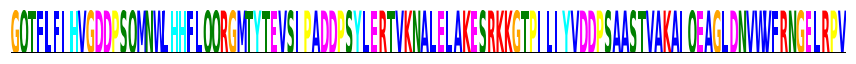

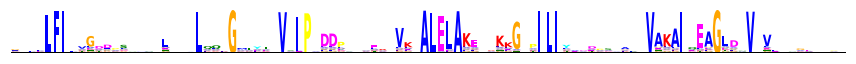

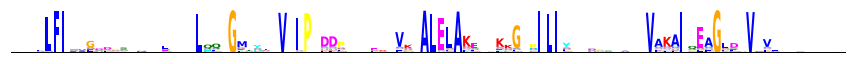

In [27]:
#Visualize a reconstructed sequence pattern

save_figs = True

for plot_i in range(0, 1) :
    
    print("Test sequence " + str(plot_i) + ":")
    
    subtracted_logits_test = (2. * np.array(x_test[plot_i:plot_i+1], dtype=np.float64) - 1.) * np.maximum(np.array(importance_scores_test[plot_i], dtype=np.float64), 1e-7)
    subtracted_pwm_test = np.exp(subtracted_logits_test) / np.expand_dims(np.sum(np.exp(subtracted_logits_test), axis=-1), axis=-1)
    
    plot_protein_logo_scrambler(residue_map, x_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=seq_length, save_figs=save_figs, fig_name=model_name + "_orig_sequence")
    plot_protein_logo_scrambler(residue_map, pwm_test[plot_i][0, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=seq_length, save_figs=save_figs, fig_name=model_name + "_scrambled_pwm")
    plot_protein_logo_scrambler(residue_map, subtracted_pwm_test[0, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=seq_length, save_figs=save_figs, fig_name=model_name + "_scrambled_pwm_no_bg")


In [28]:

importance_scores = np.concatenate(importance_scores_test, axis=0)


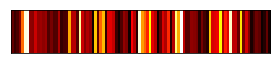

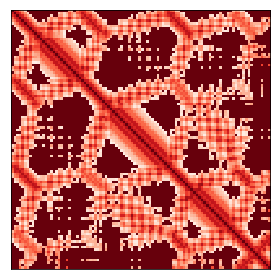

In [29]:
#Visualize importance scores

save_figs = True

f = plt.figure(figsize=(4, 1))

plt.imshow(importance_scores.reshape(1, -1), aspect='auto', cmap="hot", vmin=0, vmax=np.max(importance_scores))

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + '_p_vis1.png', transparent=True, dpi=150)
    plt.savefig(model_name + '_p_vis1.svg')
    plt.savefig(model_name + '_p_vis1.eps')

plt.show()

f = plt.figure(figsize=(4, 4))

p_keras_vals = np.argmax(pd[0, ...], axis=-1)

plt.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + '_p_vis2.png', transparent=True, dpi=150)
    plt.savefig(model_name + '_p_vis2.svg')
    plt.savefig(model_name + '_p_vis2.eps')

plt.show()


In [30]:
#Test reconstructive ability on scrambled samples

scrambled_pwm = pwm_test[0][0, 0, :, :]

n_test_samples = 512

nts = np.arange(20)

test_samples = np.zeros((n_test_samples, 1, scrambled_pwm.shape[0], scrambled_pwm.shape[1]))
for sample_ix in range(n_test_samples) :
    for j in range(scrambled_pwm.shape[0]) :
        
        rand_nt = np.random.choice(nts, p=scrambled_pwm[j, :])
        test_samples[sample_ix, 0, j, rand_nt] = 1.

test_samples_msa = np.concatenate([
    test_samples,
    np.zeros((test_samples.shape[0], test_samples.shape[1], test_samples.shape[2], 1))
], axis=-1)


In [31]:
#Test predictor on scrambled sequences

pd_scrambled, pt_scrambled, pp_scrambled, po_scrambled = predictor.predict(x=[test_samples[:, 0, :, :], test_samples_msa], batch_size=4)


Mean KL Div = 2.825
Median KL Div = 2.777


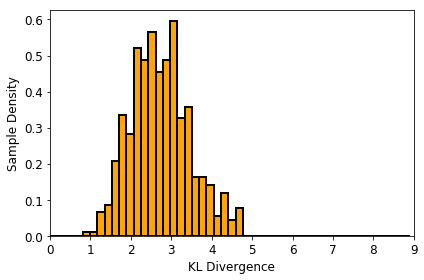

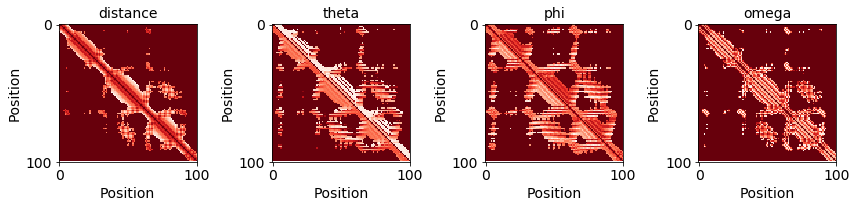

In [32]:
#Calculate KL-divergences to unscrambled distributions

def _get_kl_divergence_numpy(p_dist, p_theta, p_phi, p_omega, t_dist, t_theta, t_phi, t_omega) :
    
    kl_dist = np.mean(np.sum(t_dist * np.log(t_dist / p_dist), axis=-1), axis=(-2, -1))
    kl_theta = np.mean(np.sum(t_theta * np.log(t_theta / p_theta), axis=-1), axis=(-2, -1))
    kl_phi = np.mean(np.sum(t_phi * np.log(t_phi / p_phi), axis=-1), axis=(-2, -1))
    kl_omega = np.mean(np.sum(t_omega * np.log(t_omega / p_omega), axis=-1), axis=(-2, -1))
    
    return kl_dist + kl_theta + kl_phi + kl_omega

save_figs = True

kl_divs = _get_kl_divergence_numpy(pd_scrambled, pt_scrambled, pp_scrambled, po_scrambled, pd, pt, pp, po)

print("Mean KL Div = " + str(round(np.mean(kl_divs), 3)))
print("Median KL Div = " + str(round(np.median(kl_divs), 3)))

kl_x_min = 0.0
kl_x_max = 9.0#3.0

n_bins = 50

kl_divs_histo, bin_edges = np.histogram(kl_divs, bins=n_bins, range=[kl_x_min, kl_x_max], density=True)

f = plt.figure(figsize=(6, 4))

plt.bar(bin_edges[:-1], kl_divs_histo, width=(kl_x_max - kl_x_min) / n_bins, edgecolor='black', color='orange', linewidth=2)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("KL Divergence", fontsize=12)
plt.ylabel("Sample Density", fontsize=12)

plt.xlim(kl_x_min, kl_x_max)

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + '_kl_hist.png', transparent=True, dpi=150)
    plt.savefig(model_name + '_kl_hist.eps')

plt.show()

#Compute mean distributions for plotting
pd_scrambled_mean = np.mean(pd_scrambled, axis=0, keepdims=True)
pt_scrambled_mean = np.mean(pt_scrambled, axis=0, keepdims=True)
pp_scrambled_mean = np.mean(pp_scrambled, axis=0, keepdims=True)
po_scrambled_mean = np.mean(po_scrambled, axis=0, keepdims=True)

f, ax_list = plt.subplots(1, 4, figsize=(12, 3))

p_list = [
    [pd_scrambled_mean, 'distance', ax_list[0]],
    [pt_scrambled_mean, 'theta', ax_list[1]],
    [pp_scrambled_mean, 'phi', ax_list[2]],
    [po_scrambled_mean, 'omega', ax_list[3]]
]

for p_keras, p_name, p_ax in p_list :

    p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

    p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

    p_ax.set_title(p_name, fontsize=14)
    p_ax.set_xlabel("Position", fontsize=14)
    p_ax.set_ylabel("Position", fontsize=14)

    plt.sca(p_ax)

    plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
    plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + '_p_mean_distribs.png', transparent=True, dpi=150)
    plt.savefig(model_name + '_p_mean_distribs.eps')

plt.show()


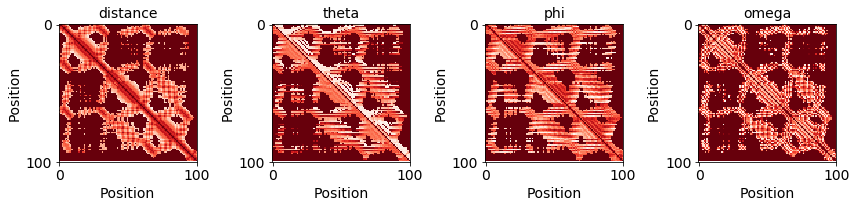

In [33]:
kl_divs_argsort = np.argsort(kl_divs)[::-1]

qt = 0.95

qt_ix = kl_divs_argsort[int(qt * kl_divs_argsort.shape[0])]

pd_scrambled_qt = pd_scrambled[qt_ix:qt_ix+1]
pt_scrambled_qt = pt_scrambled[qt_ix:qt_ix+1]
pp_scrambled_qt = pp_scrambled[qt_ix:qt_ix+1]
po_scrambled_qt = po_scrambled[qt_ix:qt_ix+1]

f, ax_list = plt.subplots(1, 4, figsize=(12, 3))

p_list = [
    [pd_scrambled_qt, 'distance', ax_list[0]],
    [pt_scrambled_qt, 'theta', ax_list[1]],
    [pp_scrambled_qt, 'phi', ax_list[2]],
    [po_scrambled_qt, 'omega', ax_list[3]]
]

for p_keras, p_name, p_ax in p_list :

    p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

    p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

    p_ax.set_title(p_name, fontsize=14)
    p_ax.set_xlabel("Position", fontsize=14)
    p_ax.set_ylabel("Position", fontsize=14)

    plt.sca(p_ax)

    plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
    plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + '_p_qt_' + str(qt).replace(".", "") + '_distribs.png', transparent=True, dpi=150)
    plt.savefig(model_name + '_p_qt_' + str(qt).replace(".", "") + '_distribs.eps')

plt.show()


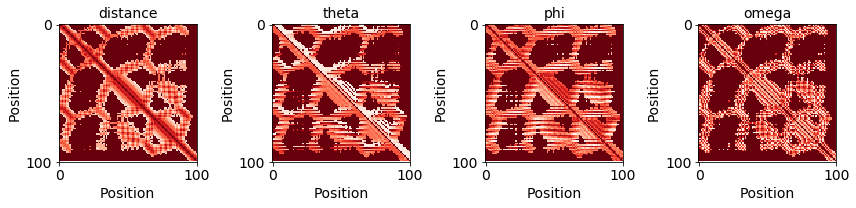

In [34]:
kl_divs_argsort = np.argsort(kl_divs)[::-1]

qt = 0.99

qt_ix = kl_divs_argsort[int(qt * kl_divs_argsort.shape[0])]

pd_scrambled_qt = pd_scrambled[qt_ix:qt_ix+1]
pt_scrambled_qt = pt_scrambled[qt_ix:qt_ix+1]
pp_scrambled_qt = pp_scrambled[qt_ix:qt_ix+1]
po_scrambled_qt = po_scrambled[qt_ix:qt_ix+1]

f, ax_list = plt.subplots(1, 4, figsize=(12, 3))

p_list = [
    [pd_scrambled_qt, 'distance', ax_list[0]],
    [pt_scrambled_qt, 'theta', ax_list[1]],
    [pp_scrambled_qt, 'phi', ax_list[2]],
    [po_scrambled_qt, 'omega', ax_list[3]]
]

for p_keras, p_name, p_ax in p_list :

    p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

    p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

    p_ax.set_title(p_name, fontsize=14)
    p_ax.set_xlabel("Position", fontsize=14)
    p_ax.set_ylabel("Position", fontsize=14)

    plt.sca(p_ax)

    plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
    plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + '_p_qt_' + str(qt).replace(".", "") + '_distribs.png', transparent=True, dpi=150)
    plt.savefig(model_name + '_p_qt_' + str(qt).replace(".", "") + '_distribs.eps')

plt.show()


In [35]:
#Save importance scores

np.save(model_name + "_importance_scores", importance_scores)
